In [28]:
import Hamiltonians.hamiltonians as ham
import Hamiltonians.helper as helper
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt

<h1> Numerical Approach 0) Set up $|\psi\rangle$ </h1>

In [29]:
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}

In [30]:
def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix

In [31]:
def psiNumerical(theta):
    '''
        represent ansatz in the Z computational basis
    '''
    Initial = np.kron(ket0,np.kron(ket0,np.kron(ket0,ket0)))
    Layer1  = np.kron(PauliX,np.kron(PauliX,np.kron(PauliI,PauliI)))
    Layer2  = np.kron(RY(theta[0]),np.kron(PauliI,np.kron(RY(theta[1]),RY(np.pi))))
    Layer3  = np.kron(cz,cz)
    Layer4  = np.kron(PauliI,np.kron(cz,PauliI))
    return Layer4@Layer3@Layer2@Layer1@Initial

<h1> Numerical Approach 1) Set up Heisenberg Hamiltonian </h1>

In [32]:
def hamiltonianMatrix(j,u,b=1.0,n=4):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for bits in combos:
        for k in range(3):
            A = [PauliI for i in range(n)]
            A[bits[0]] = PauliVec[k]
            A[bits[1]] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                add = np.kron(add, A[qbit])
            H += x*add
            
    for i in range(n):
        A = [PauliI for i in range(n)]
        A[i] = PauliZ
        add = [1]
        for qbit in range(n):
                add = np.kron(add, A[qbit])
        H += b * add
    return H

<h1> Numerical Approach 2) Set up $\tilde M$ and $\tilde Y$ </h1>

In [33]:
def tildeM(K, psiN, hamMat):
    M = np.zeros((K-1,K-1), dtype=complex)
    for i in range(1,K):
        for j in range(1,K):
            M[i-1,j-1] = np.conjugate(psiN).T @ (np.linalg.matrix_power(hamMat, 2*K-i-j)) @ psiN
    return M

def tildeY(K, psiN, hamMat):
    Y = np.zeros(K-1, dtype=complex)
    for i in range(1,K):
        Y[i-1] = np.conjugate(psiN).T @ (np.linalg.matrix_power(hamMat, 2*K-i)) @ psiN
    return Y

<h1> Numerical Approach 3) Solve $\tilde M \cdot \tilde X = -\tilde Y$ </h1>

In [34]:
psiN_ = psiNumerical([-2,1])
hamMat_ = hamiltonianMatrix(1,1,1,4)
K = 4
M_ = tildeM(K,psiN_, hamMat_)
Y_ = tildeY(K,psiN_, hamMat_)
X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
assert np.allclose(np.dot(M_,X_), -Y_)
print("Successly found X_")

Successly found X_


<h1> Numerical Approach 4) Calculate $a_is$ </h1>

Recall that we want to solve

$$Poly(a) = 0 = a^K + \sum_{i=1}^K \tilde X_i a^{K-i}$$

In [35]:
def removeLargeImaginary(roots, threshold=1e-8):
    real_roots = []
    for root in roots:
        if root.imag < threshold:
            real_roots+=[root.real]
    return real_roots

In [36]:
X_

array([  2.72434446+0.j, -34.70331045+0.j, -99.78042247+0.j])

In [37]:
coeffs

array([   1.        ,    3.62390421,  -41.50639717, -146.77109015,
        198.54973096,  587.81825535,    1.        ])

In [38]:
Js = np.linspace(0, 1, 5)
Us = np.linspace(0, 1, 5)
Js,Us = np.meshgrid(Js, Us)
Z = np.zeros(Js.shape)
for i in range(len(Js)):
    for j in range(len(Js[i])):
        K=6
        hamMat_ = hamiltonianMatrix(Js[i,j], Us[i,j])
        M_ = tildeM(K,psiN_, hamMat_)
        Y_ = tildeY(K,psiN_, hamMat_)
        X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
        coeffs = np.ones(K+1)
        for k in range(1,K):
            coeffs[k] = X_[k-1].real
        ais =removeLargeImaginary(np.roots(coeffs))
        Z[i,j] += np.min(ais)
        

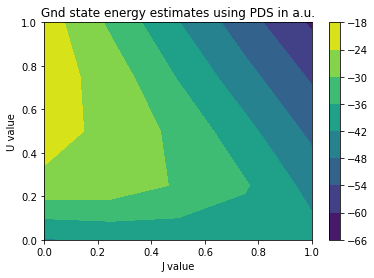

In [45]:
plt.contourf(Js,Us,Z)
plt.xlabel("J value")
plt.ylabel("U value")
plt.title("Gnd state energy estimates using PDS in a.u.")
plt.colorbar()

In [40]:
Ks = [int(i) for i in range (2,12)]
minEnergies = []
for k in Ks:
    for i in range(len(Js)):
        for j in range(len(Js[i])):
            hamMat_ = hamiltonianMatrix(Js[i,j], Us[i,j])
            M_ = tildeM(k,psiN_, hamMat_)
            Y_ = tildeY(k,psiN_, hamMat_)
            X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
            coeffs = np.ones(k+1)
            for l in range(1,k):
                coeffs[l] = X_[l-1].real
            ais =removeLargeImaginary(np.roots(coeffs))
            Z[i,j] += np.min(ais)   
            ais =removeLargeImaginary(np.roots(coeffs))
    minEnergies += [np.min(ais)]

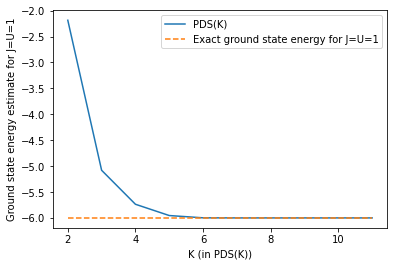

In [41]:
plt.plot(Ks, minEnergies,label="PDS(K)")
plt.plot([Ks[0],Ks[-1]], [-6,-6],linestyle="dashed",label="Exact ground state energy for J=U=1")
plt.xlabel("K (in PDS(K))")
plt.ylabel("Ground state energy estimate for J=U=1")
plt.legend()